In [1]:
import torch 
import random
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append("..")

from forecaster import Forecaster, PatchFMConfig, plot_forecast
from dataset import UTSDataset

/home/svilhes/anaconda3/envs/anots/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [24]:
# --- Instantiate model ---
config = PatchFMConfig()
config.ckpt_path = "../ckpts/huge_v2.pth"

if "huge" in config.ckpt_path:
    config.n_heads = 64
    config.d_model = 2048

model = Forecaster(config)

# Forecasting

In [3]:
# --- Load an artificial dataset ---
#dataset = torch.load("../data/full.pt") # approx 40sec to load
dataset = UTSDataset(input_len=1024, output_len=model.patch_len, flag="val")

Indexing dataset...


100%|██████████| 68679/68679 [00:27<00:00, 2456.66it/s]


Context shape: torch.Size([1, 1024]), Target shape: torch.Size([32])


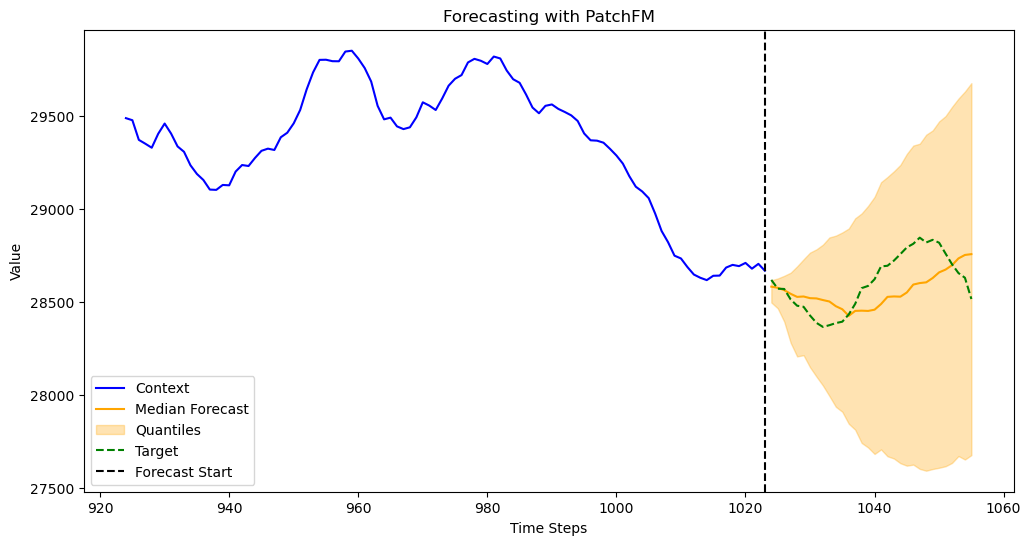

In [48]:
idx = random.randint(0, len(dataset))
context, target = dataset[idx]
xx = torch.cat([context, target], dim=0)

context_size = 1024
forecast_horizon = 32
context_plot_limit = 100

context = xx[:context_size].unsqueeze(0)
target = xx[context_size:forecast_horizon + context_size]

print(f"Context shape: {context.shape}, Target shape: {target.shape}")

pred_median, pred_quantiles = model(context, forecast_horizon=forecast_horizon, quantiles=[0.1, 0.5, 0.9])

plot_forecast(context, pred_median, pred_quantiles, target_pred=target, context_plot_limit=context_plot_limit)

# Anomaly Detection

In [42]:
from anomaly_detection.dataset_example import get_data

test = get_data(window_size=1024, root_dir='../anomaly_detection/', dataset="ec2_request_latency_system_failure")

In [43]:
scores = []

for x, y in test:
    score = model.anomaly_scorer(x)
    scores.append(score)

In [44]:
values  = [x[0][-1].squeeze().numpy().item() for x in test]
labels  = [x[1] for x in test]

In [45]:
from sklearn.metrics import roc_auc_score
auc = roc_auc_score(labels, scores)
print(f"AUC: {auc:.4f}")

AUC: 0.9733


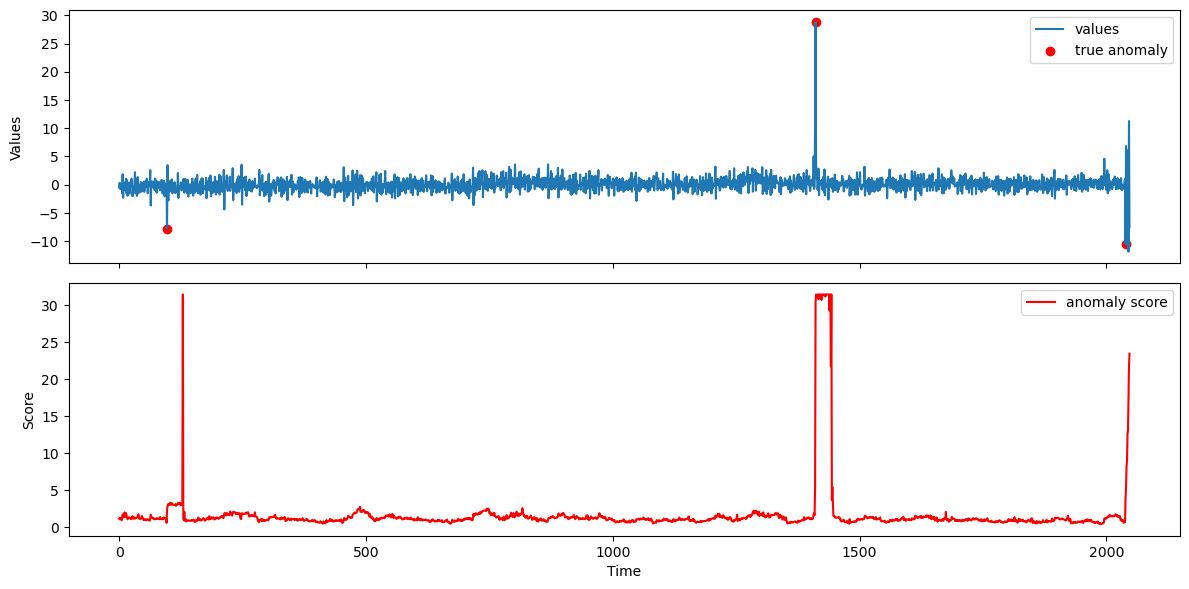

In [46]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

# --- First plot: values + anomalies ---
ax1.plot(range(len(values)), values, label="values")
ax1.scatter(
    [i for i in range(len(values)) if labels[i] == 1],
    [values[i] for i in range(len(values)) if labels[i] == 1],
    color='red', label="true anomaly"
)
ax1.legend()
ax1.set_ylabel("Values")

threshold = np.percentile(scores, 99)
clipped_scores = np.clip(scores, None, threshold)

ax2.plot(range(len(clipped_scores)), clipped_scores, label="anomaly score", color='red')
ax2.legend()
ax2.set_xlabel("Time")
ax2.set_ylabel("Score")

plt.tight_layout()
plt.show()